In [302]:
N = 24
cols = ['Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours', 'Screen_Time_Before_Bed', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education']
target_col = cols[N % 7]
print(target_col)

Screen_Time_Before_Bed


Данные для обработки будут браться из столбца Screen_Time_Before_Bed датасета teen_phone_addiction_dataset.csv:

In [303]:
import pandas as pd
df = pd.read_csv('../../datasets/teen_phone_addiction_dataset.csv')
data = df[target_col]
print(data)

0       1.4
1       0.9
2       0.5
3       1.4
4       1.0
       ... 
2995    0.3
2996    0.9
2997    0.2
2998    1.6
2999    0.6
Name: Screen_Time_Before_Bed, Length: 3000, dtype: float64


## I. 

In [304]:
mean = data.mean()
var = data.var()
mode = data.mode()[0]
median = data.median()
quantiles = data.quantile([0.25, 0.5, 0.75])
kurtosis = data.kurtosis()
skewness = data.skew()
iqr = quantiles[0.75] - quantiles[0.25]


print("Характеристики данных:")
print(f"1. Среднее: {mean:.4f}")
print(f"2. Дисперсия: {var:.4f}")
print(f"3. Мода: {mode:.4f}")
print(f"4. Медиана: {median:.4f}")
print(f"5. Квантили (0.25, 0.5, 0.75): {quantiles.values}")
print(f"6. Эксцесс: {kurtosis:.4f}")
print(f"7. Асимметрия: {skewness:.4f}")
print(f"8. Интерквартильный размах: {iqr:.4f}")

Характеристики данных:
1. Среднее: 1.0067
2. Дисперсия: 0.2429
3. Мода: 1.0000
4. Медиана: 1.0000
5. Квантили (0.25, 0.5, 0.75): [0.7 1.  1.4]
6. Эксцесс: -0.3489
7. Асимметрия: 0.0984
8. Интерквартильный размах: 0.7000


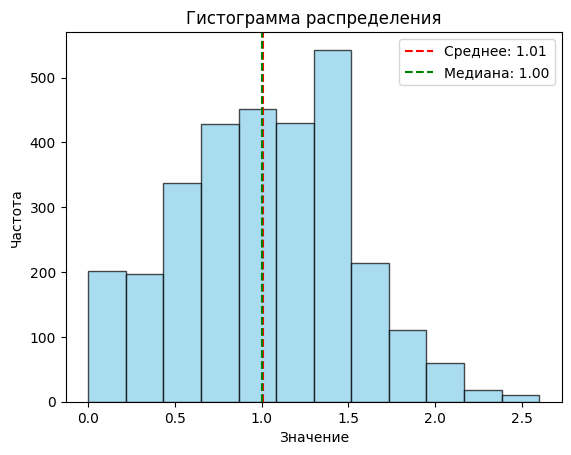

In [305]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(1, 1)

ax1.hist(data, bins=1+int(np.log2(len(data))), alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(mean, color='red', linestyle='--', label=f'Среднее: {mean:.2f}')
ax1.axvline(median, color='green', linestyle='--', label=f'Медиана: {median:.2f}')
ax1.set_title('Гистограмма распределения')
ax1.set_xlabel('Значение')
ax1.set_ylabel('Частота')
ax1.legend()

Text(0, 0.5, 'F(x)')

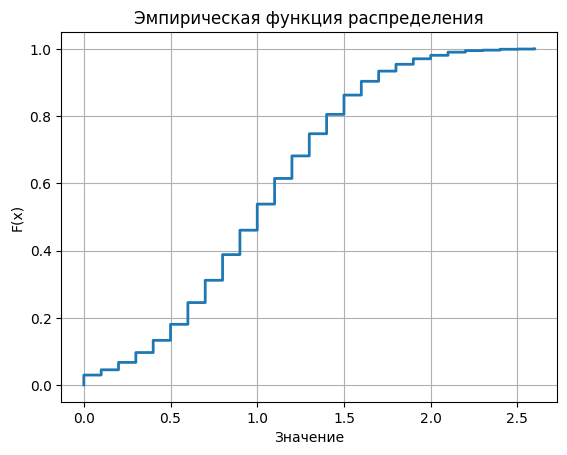

In [306]:
fig, ax1 = plt.subplots(1, 1)

sorted_data = np.sort(data)
y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax1.step(sorted_data, y, where='post', linewidth=2)
ax1.grid(True)
ax1.set_title('Эмпирическая функция распределения')
ax1.set_xlabel('Значение')
ax1.set_ylabel('F(x)')


Исходя из полученных числовых характеристик и графиков можно сделать вывод, что распределение данных скошено вправо. Во-первых, это следует из коэффициента ассиметрии > 0. При этом, As < 0.25, поэтому можно говорить, что асимметрия мала. Кроме того на асимметрию также указывает соотношение Mo <= Me < X_ср.

## II. 

In [307]:
from scipy import stats
import math

def chi_square_test(data, alpha=0.05):
    n = len(data)
    k = int(1 + 3.322 * math.log10(n))
    min_val, max_val = data.min(), data.max()
    intervals = np.linspace(min_val, max_val, k + 1)
    observed, _ = np.histogram(data, bins=intervals)
    
    mean, std = data.mean(), data.std()
    expected = np.zeros(k)
    for i in range(k):
        p = stats.norm.cdf(intervals[i+1], mean, std) - stats.norm.cdf(intervals[i], mean, std)
        expected[i] = p * n
    expected = np.where(expected == 0, 1e-10, expected)

    chi2_stat = np.sum((observed - expected)**2 / expected)
    deg = k - 3
    critical_value = stats.chi2.ppf(1 - alpha, deg)
    return chi2_stat < critical_value

In [308]:
chi2_test_result = chi_square_test(data)
print(chi2_test_result)

False


In [309]:
_, p_val = stats.normaltest(data)
print(p_val > 0.05)

False


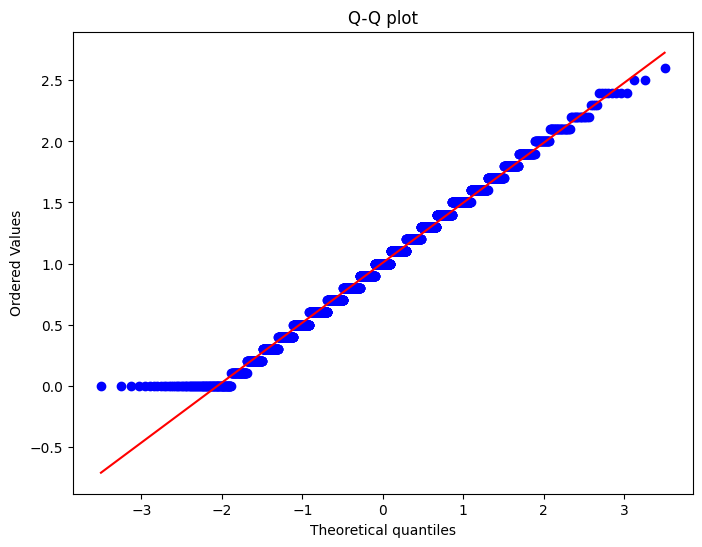

In [310]:
plt.figure(figsize=(8, 6))
stats.probplot(data, dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.show()

Таким образом, оба теста отвергают гипотезу о нормальном распределении данных. Кроме того и график Q-Q также показывает, что на концах наблюдаемое распределение отличается от нормального. 

## III. 

Text(0.5, 1.0, 'После преобразования')

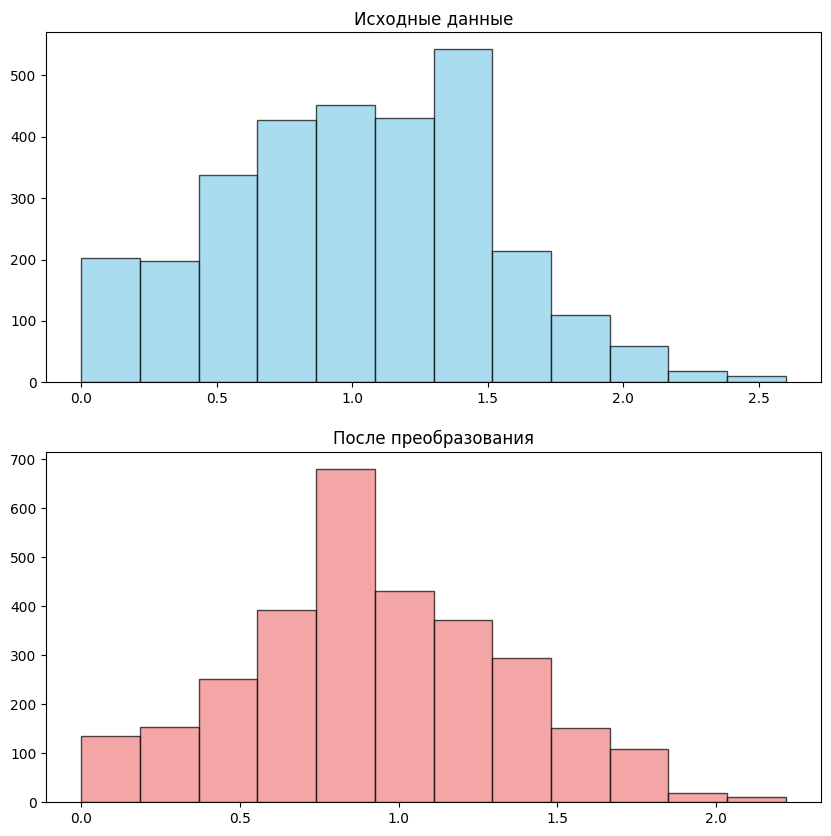

In [311]:
newdata, _ = stats.yeojohnson(data)
data_transformed = pd.Series(newdata)

bins=1+int(np.log2(len(data)))

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].hist(data, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Исходные данные')

axes[1].hist(data_transformed, bins=bins, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_title('После преобразования')

Заметно, что преобразование Йео-Джонсона привело распределение данных к визуально более похожему на нормальное. Кроме того, имеет место значительное улучшение асимметрии и незначительное ухудшение эксцесса (В след. пункте). Далее первые два пункта работы будем применять к преобразованным данным.

In [312]:
mean_new = data_transformed.mean()
var_new = data_transformed.var()
mode_new = data_transformed.mode()[0]
median_new = data_transformed.median()
quantiles_new = data_transformed.quantile([0.25, 0.5, 0.75])
kurtosis_new = data_transformed.kurtosis()
skewness_new = data_transformed.skew()
iqr_new = quantiles_new[0.75] - quantiles_new[0.25]


print("Характеристики данных:")
print(f"1. Среднее: {mean_new:.4f}")
print(f"2. Дисперсия: {var_new:.4f}")
print(f"3. Мода: {mode_new:.4f}")
print(f"4. Медиана: {median_new:.4f}")
print(f"5. Квантили (0.25, 0.5, 0.75): {quantiles_new.values}")
print(f"6. Эксцесс: {kurtosis_new:.4f}")
print(f"7. Асимметрия: {skewness_new:.4f}")
print(f"8. Интерквартильный размах: {iqr_new:.4f}")

Характеристики данных:
1. Среднее: 0.9186
2. Дисперсия: 0.1839
3. Мода: 0.9239
4. Медиана: 0.9239
5. Квантили (0.25, 0.5, 0.75): [0.65971462 0.9239078  1.26377565]
6. Эксцесс: -0.3716
7. Асимметрия: -0.0289
8. Интерквартильный размах: 0.6041


In [313]:
chi2_test_result = chi_square_test(data_transformed)
print(chi2_test_result)

False


In [314]:
_, p_val = stats.normaltest(data_transformed)
print(p_val > 0.05)

False


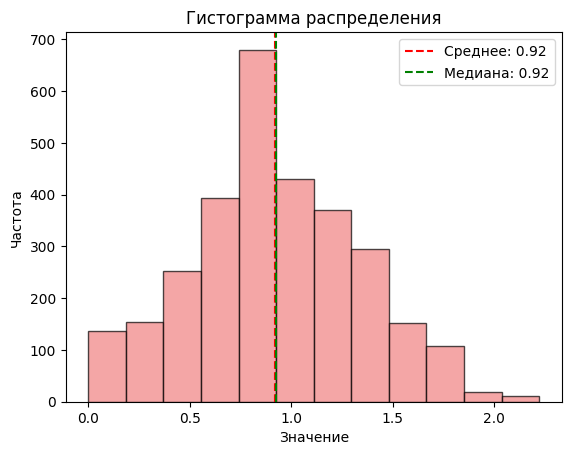

In [315]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(1, 1)

ax1.hist(data_transformed, bins=1+int(np.log2(len(data))), alpha=0.7, color='lightcoral', edgecolor='black')
ax1.axvline(mean_new, color='red', linestyle='--', label=f'Среднее: {mean_new:.2f}')
ax1.axvline(median_new, color='green', linestyle='--', label=f'Медиана: {median_new:.2f}')
ax1.set_title('Гистограмма распределения')
ax1.set_xlabel('Значение')
ax1.set_ylabel('Частота')
ax1.legend()

Text(0, 0.5, 'F(x)')

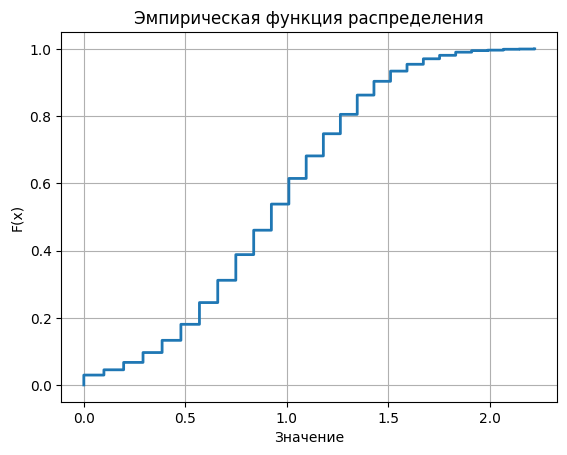

In [316]:
fig, ax1 = plt.subplots(1, 1)

sorted_data = np.sort(data_transformed)
y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax1.step(sorted_data, y, where='post', linewidth=2)
ax1.grid(True)
ax1.set_title('Эмпирическая функция распределения')
ax1.set_xlabel('Значение')
ax1.set_ylabel('F(x)')

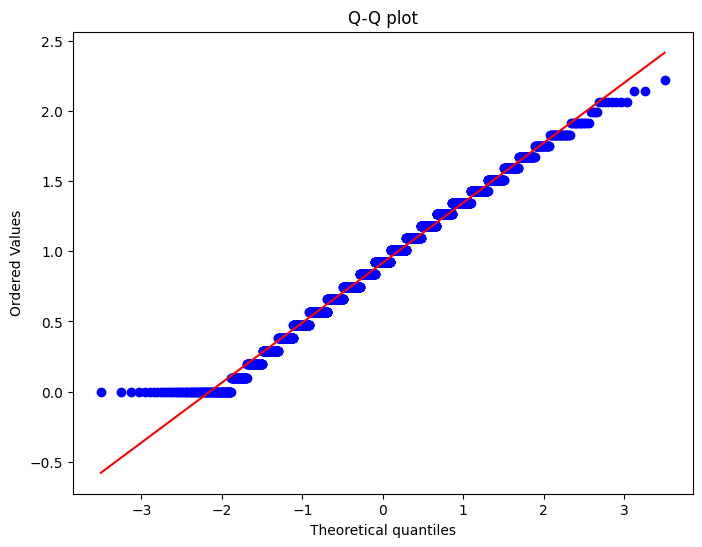

In [317]:
plt.figure(figsize=(8, 6))
stats.probplot(data_transformed, dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.show()

Исследуя полученные результаты нетрудно видеть, что преобразованные данные стали ближе к нормальному распределению, чем исходные, но все же отвергаются критериями. Таким образом сновная часть данных соответствует нормальному распределению, однако концы выборки требуют дополнительной обработки. 

## IV.

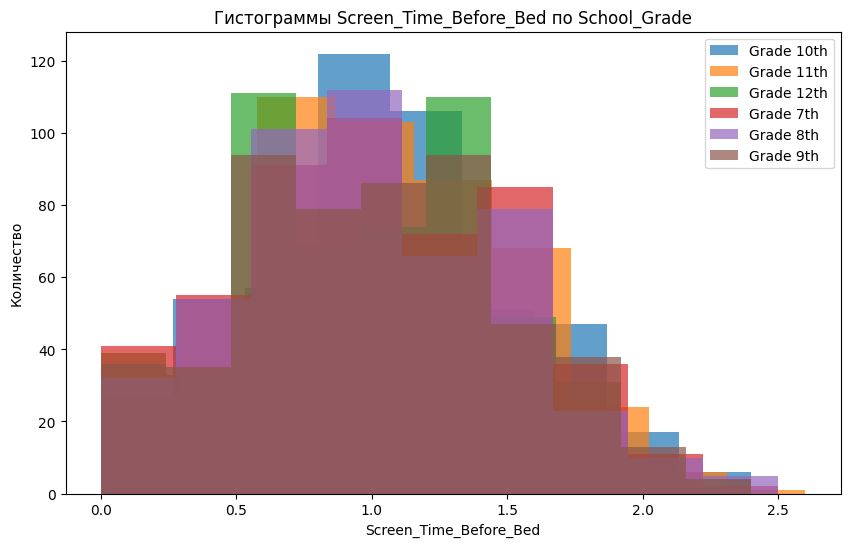


Статистики по группам School_Grade:
Grade 10th: Среднее = 1.02094, Дисперсия = 0.24096
Grade 11th: Среднее = 1.02255, Дисперсия = 0.23351
Grade 12th: Среднее = 0.98242, Дисперсия = 0.24376
Grade 7th: Среднее = 1.00664, Дисперсия = 0.25469
Grade 8th: Среднее = 1.00519, Дисперсия = 0.24137
Grade 9th: Среднее = 1.00513, Дисперсия = 0.24411


In [318]:
groups = df.groupby('School_Grade')

plt.figure(figsize=(10,6))

stats_dict = {}
for i, (grade, group_data) in enumerate(groups):
    values = group_data[target_col]
    mean_val = values.mean()
    var_val = values.var()
    stats_dict[grade] = {'mean': mean_val, 'variance': var_val}

    bins = 1 + int(np.log2(len(values)))
    
    plt.hist(values, bins=bins, alpha=0.7, label=f'Grade {grade}')

plt.title(f'Гистограммы {target_col} по School_Grade')
plt.xlabel(target_col)
plt.ylabel('Количество')
plt.legend()
plt.show()

print(f"\nСтатистики по группам School_Grade:")
for grade, stats in stats_dict.items():
    print(f"Grade {grade}: Среднее = {stats['mean']:.5f}, Дисперсия = {stats['variance']:.5f}")

 На основе проведенного анализа можно сделать следующие выводы. Величина средних значений очень близка у всех групп и колеблется в узком диапазоне. Касательно дисперсий, разброс данных внутри каждой группы практически одинаков. Нельзя сказать, что в каком-то классе поведение учащихся разнородно по сравнению с другими. Тем не менее, значения мод в каждой из групп различаются. Таким образом, принадлежность к тому или иному классу в данной выборке не является фактором, который сколь-либо существенно влияет на продолжительность использования экранов перед сном. Все группы демонстрируют очень схожую картину.